# Practice 2

Student 1: Alejandro González Álvarez

NIA 1: 252658

Student 2: Luca Franceschi

NIA 2: 253885

Student 3: Júlia Othats-Dalès

NIA 3: 254435

# Imports

In [1]:
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Google Drive (or not)

In [2]:
# Comment if not in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# datadir = '/content/drive/My Drive/DeepLearning_2024/P2/MaterialP2/Data/'
datadir = 'Data/'

# GPU Acceleration (or not)

In [3]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Ex.1 - Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs

In [4]:
'''
Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs
Steps :
1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.
2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:
  -   Adapt the classification loss and the SequenceClassifier module
  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix
3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.
4. Visualize analyse and discuss the results in the report.
'''

"\nExperimenting with Multi-Class Sequence Classification using RNNs and LSTMs\nSteps :\n1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.\n2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:\n  -   Adapt the classification loss and the SequenceClassifier module\n  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix\n3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.\n4. Visualize analyse and discuss the results in the report.\n"

# Sol 1.

Train Seqs: (210, 40)
Train Labels: (210,)
Test Seqs: (90, 40)
Test Labels: (90,)


C:\Users\alex4\AppData\Local\Temp\ipykernel_8088\346631005.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


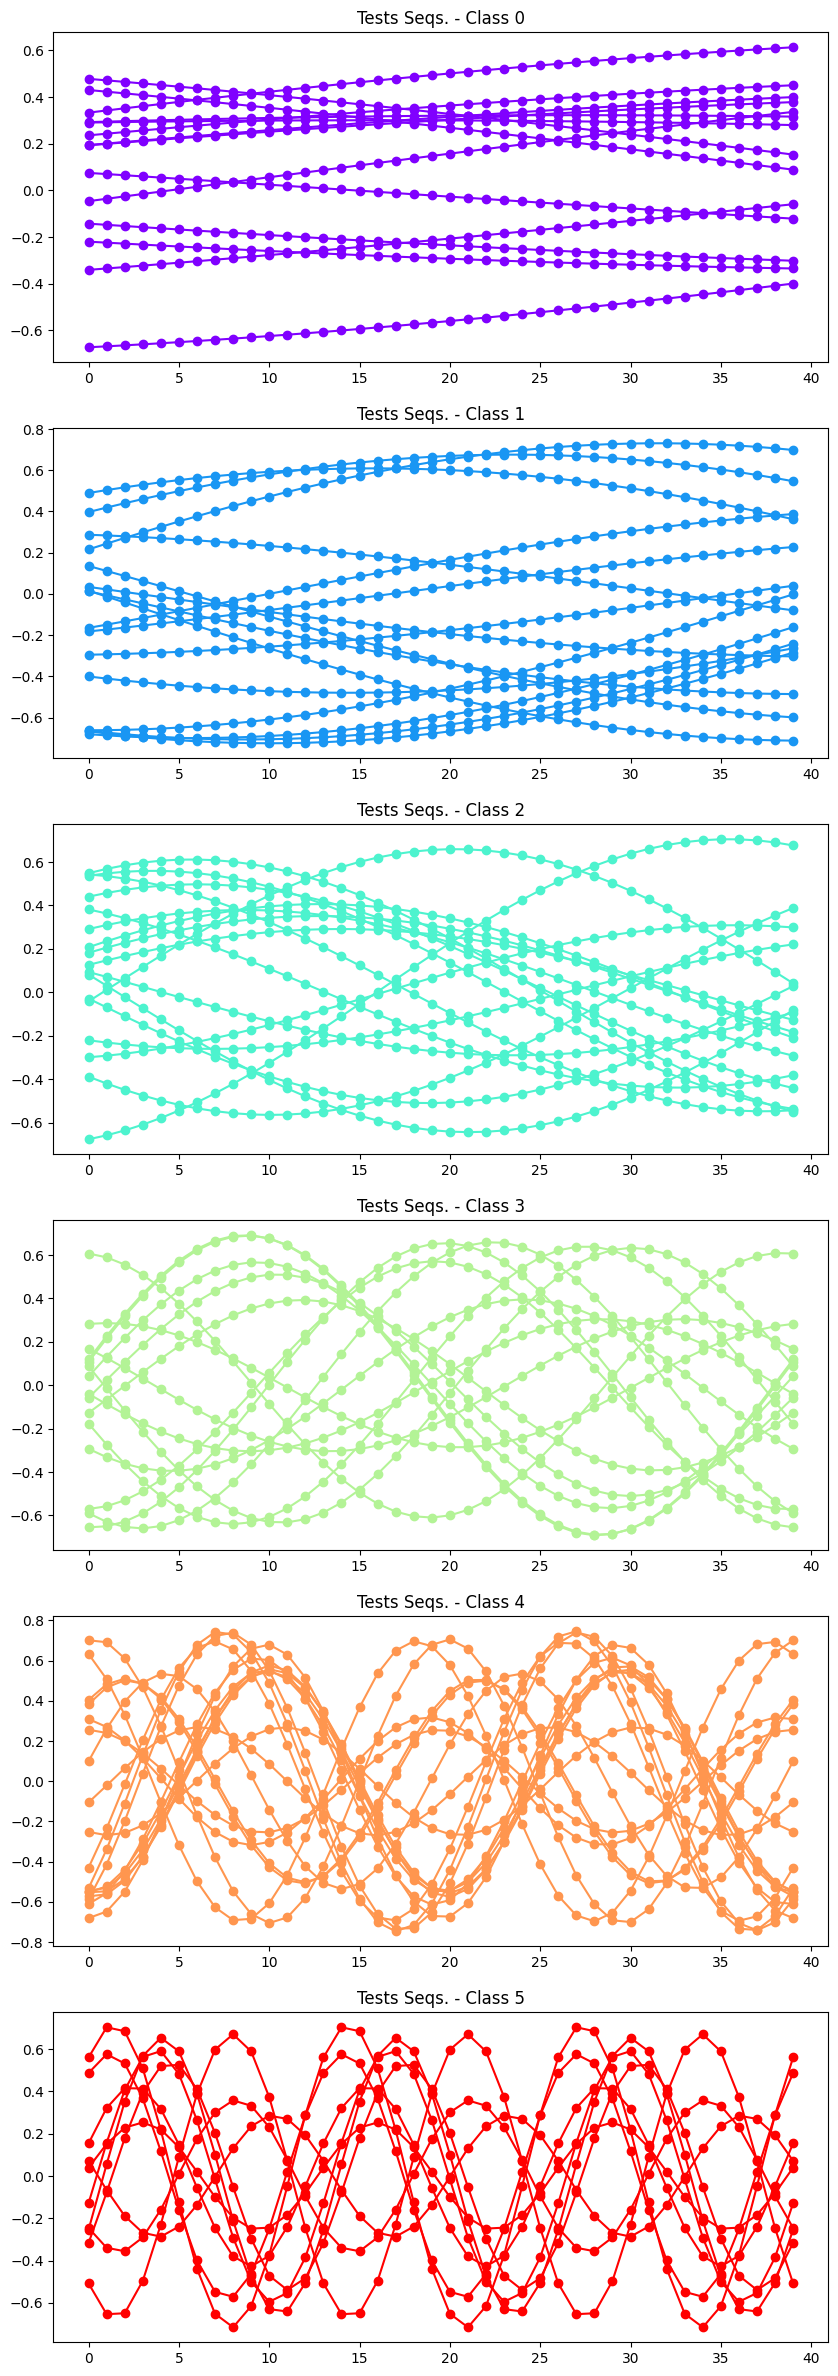

In [5]:
# 1. Load and visualize the training and testing data
data = np.load(datadir+'P2_E1.npz')
X_train, X_test = data['X_train'], data['X_test']
Y_train, Y_test = data['Y_train'], data['Y_test']

print(f'Train Seqs: {X_train.shape}')
print(f'Train Labels: {Y_train.shape}')
print(f'Test Seqs: {X_test.shape}')
print(f'Test Labels: {Y_test.shape}')

classes = np.unique(Y_train)
n_classes = len(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

fig, axs = plt.subplots(n_classes, 1, figsize=(10, 5*n_classes))
for class_idx in range(0, n_classes):
    axs[class_idx].plot(X_test[Y_test == class_idx, :].T, '-o', c=colors[class_idx])
    axs[class_idx].set_title(f'Tests Seqs. - Class {class_idx}')
fig.show()

In [6]:
# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters

class SequenceClassifier(nn.Module):
    def __init__(self,
                 input_size : int = 1,
                 hidden_size : int = 5,
                 num_layers = 1,
                 num_classes : int = 6,
                 use_lstm : bool = False):
        # Define RNN or LSTM architecture
        super().__init__()
        self.use_lstm = use_lstm
        if(use_lstm):
            self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                               num_layers=num_layers, batch_first = True)
        else:
            self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size,
                              num_layers=num_layers, batch_first = True)
        self.softmax = nn.Softmax(dim=1)
        self.last_linear = nn.Linear(hidden_size, num_classes)  # 6 is number of different classes

    def forward(self, X):
        _, last_states = self.rnn(X)
        # Get last hidden state for last layer. Ignore cell state in case of LSTMs
        if(not self.use_lstm):
            last_hidden_state = last_states[-1,:,:].squeeze(0)
        else:
            last_hidden_state = last_states[0][-1,:,:].squeeze(0)
        # Get sequence label probability using the last hidden state
        output = self.softmax(self.last_linear(last_hidden_state))  # Using softmax instead of sigmoid
        return output

In [7]:
# Define the training model
def train_multiclass_classifier(X_train, Y_train, classifier, optimizer, loss_func, epochs=100):
    loss_epochs = []
    for epoch in range(epochs):
            optimizer.zero_grad()
            output = classifier(X_train)
            loss = loss_func(output, Y_train)
            loss_epochs.append(loss.item())
            loss.backward()
            optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_epochs)

# Adapt the test_sequence_classifier function
def test_multiclass_classifier(X_test, Y_test, classifier):
    output = classifier(X_test)
    predicted_labels = torch.argmax(output, dim=1)
    correct_predictions = (predicted_labels == Y_test).sum().item()
    total_samples = len(Y_test)
    accuracy = correct_predictions / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y_test.to(device), predicted_labels.to(device))

    return accuracy, conf_matrix

Training: H1_NL1_LSTM0
Final loss: 1.7646903991699219
Test Accuracy: 0.2111
Training: H5_NL2_LSTM1
Final loss: 1.4293776750564575
Test Accuracy: 0.5667


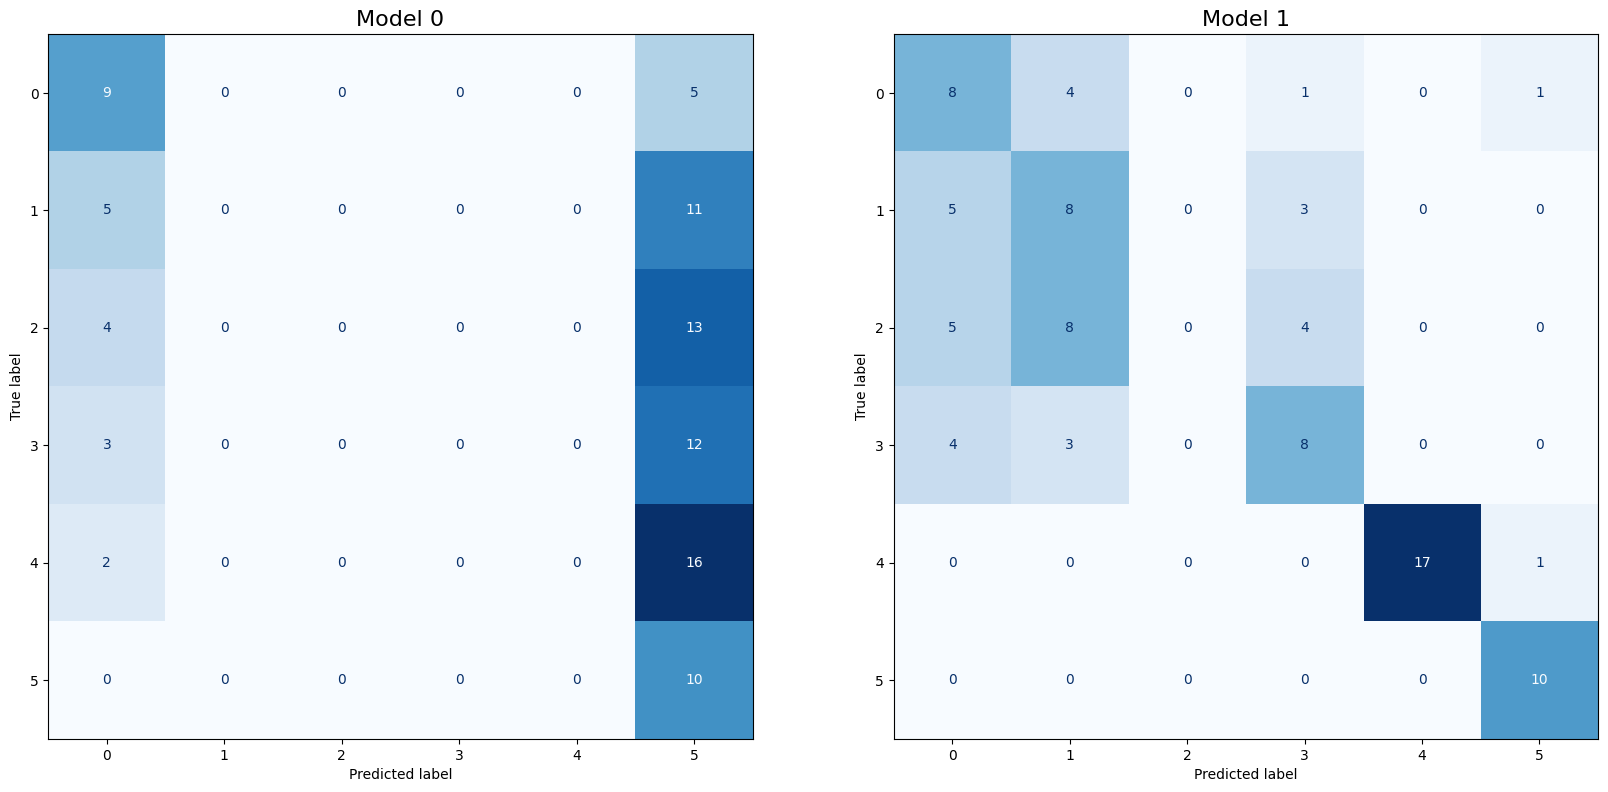

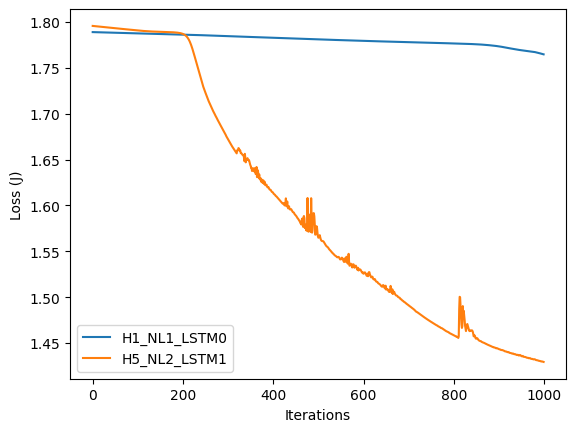

,H1_NL1_LSTM0,H5_NL2_LSTM1
accuracy %,21.111111,56.666667


In [8]:
X_train_pt = torch.from_numpy(X_train).float().unsqueeze(2).to(device)
Y_train_pt = torch.from_numpy(Y_train).long().to(device)
X_test_pt = torch.from_numpy(X_test).float().unsqueeze(2).to(device)
Y_test_pt = torch.from_numpy(Y_test).long().to(device)

loss_func = nn.CrossEntropyLoss()

exp_hidden_size = [1, 5]
exp_num_layers = [1, 2]
exp_use_lstm = [False, True]

losses_models = {}
test_accuracy_models = {}
confusion_matrices = {}

for hidden_size, num_layers, use_lstm in zip(exp_hidden_size, exp_num_layers, exp_use_lstm):
    model_id = f'H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}'
    print(f'Training: {model_id}')

    seq_classifier = SequenceClassifier(use_lstm=use_lstm, num_layers=num_layers, hidden_size=hidden_size)
    seq_classifier.to(device)

    optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=1e-3)

    losses_models[model_id] = train_multiclass_classifier(X_train_pt, Y_train_pt,
                                                          seq_classifier, optimizer,
                                                          loss_func, epochs=1000)

    test_accuracy_models[model_id], confusion_matrices[model_id] = test_multiclass_classifier(X_test_pt, Y_test_pt, seq_classifier)

#Plot confusion matrices
f, axes = plt.subplots(1, 2, figsize=(20, 20))

a = [axes[0], axes[1]]
ctr = 0
for model, cm in confusion_matrices.items():
    ConfusionMatrixDisplay(cm).plot(include_values=True, cmap="Blues", ax=a[ctr], colorbar=False, values_format=".0f")
    a[ctr].set_title("Model " + str(ctr), size=16)
    ctr += 1

plt.show()

for loss_it in losses_models.values():
    plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.xlabel("Iterations")
plt.ylabel("Loss (J)")
plt.show()

pd.DataFrame(np.asarray(list(test_accuracy_models.values()))*100, columns=['accuracy %'],
             index=test_accuracy_models.keys()).transpose()

In [19]:
# 3. Experiment with different models by changing different hyper-parameters
# (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate the results for each of them on the testing set.

# For this we will create a function that generalizes the code above, and we will change one parameter at a time in the following cells.
# IMPORTANT: this function assumes that the input are 8 HMMs at a time, it is important to put 8 as input for the plots to be displayed correctly.

def evaluateModels(exp_hidden_size, exp_num_layers, exp_use_lstm, optimizers=["default"]*8, lr=1e-3, epochs=1000):
    if len(exp_hidden_size) != 8:
        print("Input 8 different models.")
        return
    
    losses_models = {}
    test_accuracy_models = {}
    confusion_matrices = {}
    model_ids = []

    chosen_optimizers = []

    for i in range(len(optimizers)):
        chosen_optimizers.append(
            torch.optim.SGD(seq_classifier.parameters(), lr=lr)
            if optimizers[i] == "SGD"
            else torch.optim.RMSprop(seq_classifier.parameters(), lr=lr)
            if optimizers[i] == "RMSprop"
            else torch.optim.Adagrad(seq_classifier.parameters(), lr=lr)
            if optimizers[i] == "Adagrad"
            else torch.optim.Adam(seq_classifier.parameters(), lr=lr)
    )
    
    print(chosen_optimizers)

    print("------------ TRAINING ------------\n")

    for hidden_size, num_layers, use_lstm in zip(exp_hidden_size, exp_num_layers, exp_use_lstm):
        model_id = f'H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}'
        model_ids.append(model_id)
        print(f'Training: {model_id}')

        seq_classifier = SequenceClassifier(use_lstm=use_lstm, num_layers=num_layers, hidden_size=hidden_size)
        seq_classifier.to(device)

        optimizer = chosen_optimizers[i]

        losses_models[model_id] = train_multiclass_classifier(X_train_pt, Y_train_pt,
                                                            seq_classifier, optimizer,
                                                            loss_func, epochs=epochs)

        test_accuracy_models[model_id], confusion_matrices[model_id] = test_multiclass_classifier(X_test_pt, Y_test_pt, seq_classifier)

    print("\n------------ CONFUSION MATRICES ------------\n")

    #Plot confusion matrices
    f, axes = plt.subplots(2, 4, figsize=(12, 8), constrained_layout=True)

    a = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3]]
    ctr = 0
    for model, cm in confusion_matrices.items():
        ConfusionMatrixDisplay(cm).plot(include_values=True, cmap="Blues", ax=a[ctr], colorbar=False, values_format=".0f")
        a[ctr].set_title(model_ids[ctr], size=16)
        ctr += 1

    plt.show()

    print("\n------------ LOSSES ------------\n")

    # Plot losses' evolutions
    for loss_it in losses_models.values():
        plt.plot(loss_it)
    plt.legend(losses_models.keys())
    plt.xlabel("Iterations")
    plt.ylabel("Loss (J)")
    plt.show()

    print("\n------------ ACCURACIES ------------\n")

    # Plot accuracies
    accuracy_df = pd.DataFrame(np.asarray(list(test_accuracy_models.values()))*100, columns=['accuracy %'],
                index=test_accuracy_models.keys()).transpose()
    print(accuracy_df.head())

    accuracies = np.asarray(list(test_accuracy_models.values()))
    return accuracies, exp_hidden_size, exp_num_layers, exp_use_lstm

------------ TRAINING ------------

Training: H1_NL1_LSTM0
Final loss: 1.776114821434021
Test Accuracy: 0.2444
Training: H5_NL1_LSTM0
Final loss: 1.5979732275009155
Test Accuracy: 0.4444
Training: H10_NL1_LSTM0
Final loss: 1.5712459087371826
Test Accuracy: 0.4667
Training: H20_NL1_LSTM0
Final loss: 1.537927269935608
Test Accuracy: 0.4778
Training: H1_NL1_LSTM1
Final loss: 1.749862551689148
Test Accuracy: 0.2222
Training: H5_NL1_LSTM1
Final loss: 1.4304499626159668
Test Accuracy: 0.5778
Training: H10_NL1_LSTM1
Final loss: 1.3939012289047241
Test Accuracy: 0.5889
Training: H20_NL1_LSTM1
Final loss: 1.3264752626419067
Test Accuracy: 0.7333

------------ CONFUSION MATRICES ------------



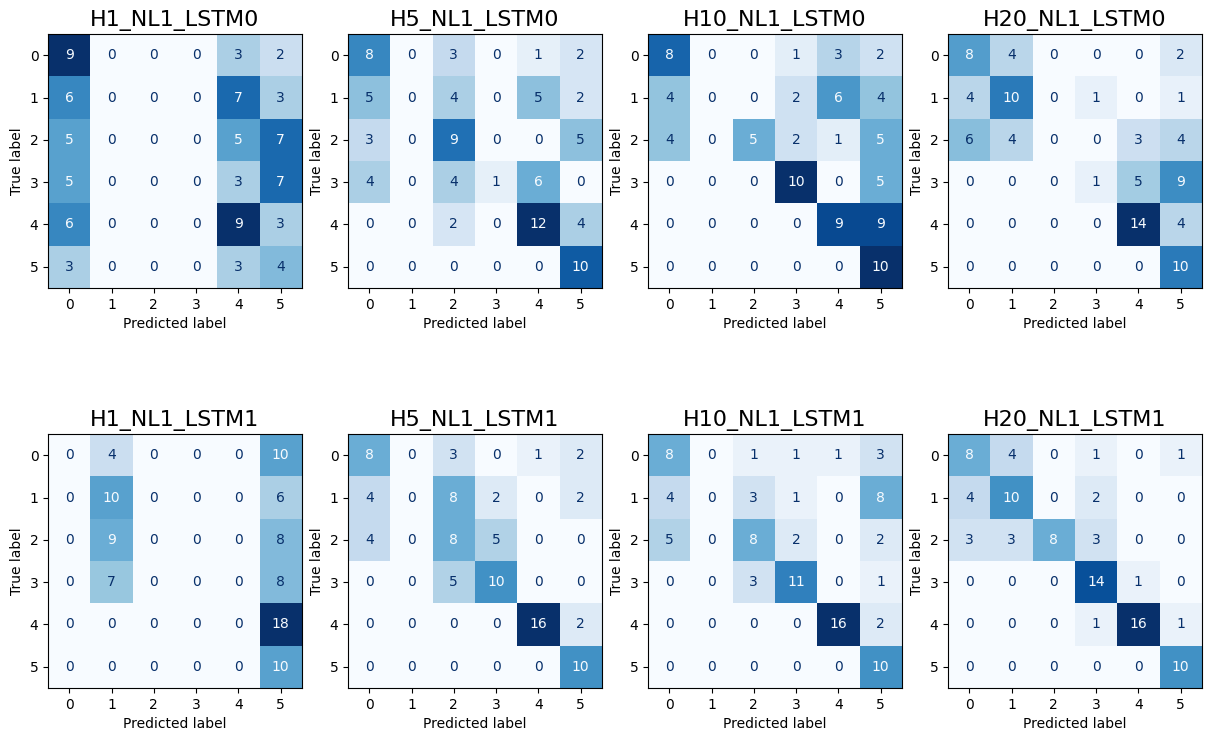


------------ LOSSES ------------



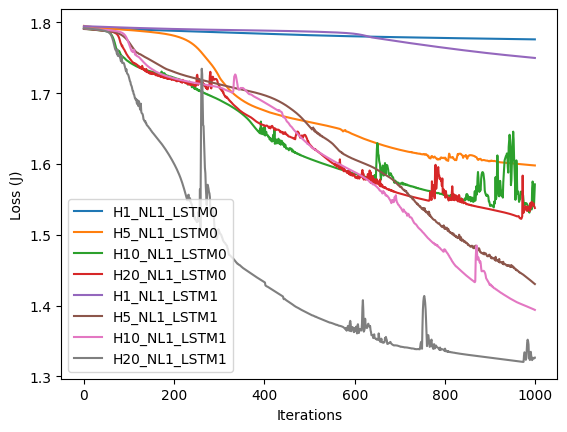


------------ ACCURACIES ------------

            H1_NL1_LSTM0  H5_NL1_LSTM0  H10_NL1_LSTM0  H20_NL1_LSTM0  \
accuracy %     24.444444     44.444444      46.666667      47.777778   

            H1_NL1_LSTM1  H5_NL1_LSTM1  H10_NL1_LSTM1  H20_NL1_LSTM1  
accuracy %     22.222222     57.777778      58.888889      73.333333  


In [10]:
# Testing different values for exp_hidden_size

exp_hidden_size = [1, 5, 10, 20] * 2
exp_num_layers = [1]*8
exp_use_lstm = [False]*4 + [True]*4

acc, hd_sz, num_lay, use_lstm = evaluateModels(exp_hidden_size=exp_hidden_size, exp_num_layers=exp_num_layers, exp_use_lstm=exp_use_lstm)

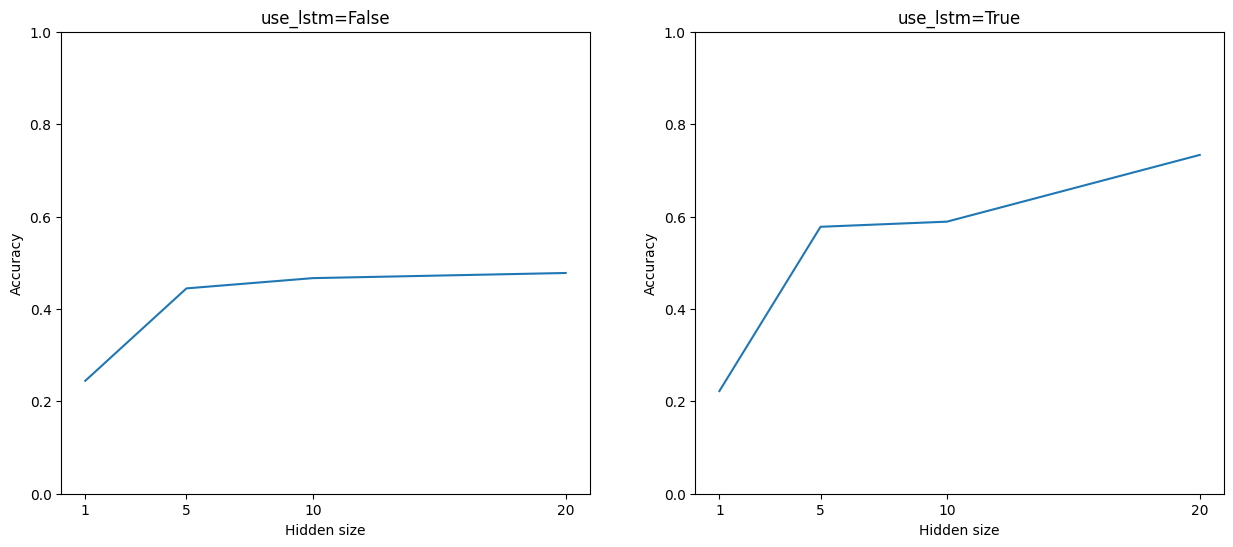

In [11]:
# Plot the evolution of accuracy with respect to hidden_size, for both lstm False and True.
f, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(hd_sz[:4], acc[:4])
axes[0].set_xlabel("Hidden size")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_title("use_lstm=False")
axes[0].set_xticks(hd_sz[:4])

axes[1].plot(hd_sz[-4:], acc[-4:])
axes[1].set_xlabel("Hidden size")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim([0, 1])
axes[1].set_title("use_lstm=True")
axes[1].set_xticks(hd_sz[-4:])

plt.show()

------------ TRAINING ------------

Training: H5_NL1_LSTM0
Final loss: 1.6826802492141724
Test Accuracy: 0.2778
Training: H5_NL2_LSTM0
Final loss: 1.624226450920105
Test Accuracy: 0.3667
Training: H5_NL3_LSTM0
Final loss: 1.5680228471755981
Test Accuracy: 0.4111
Training: H5_NL4_LSTM0
Final loss: 1.5822865962982178
Test Accuracy: 0.3778
Training: H5_NL1_LSTM1
Final loss: 1.5630896091461182
Test Accuracy: 0.3667
Training: H5_NL2_LSTM1
Final loss: 1.3870975971221924
Test Accuracy: 0.6000
Training: H5_NL3_LSTM1
Final loss: 1.3603023290634155
Test Accuracy: 0.6667
Training: H5_NL4_LSTM1
Final loss: 1.4664406776428223
Test Accuracy: 0.5667

------------ CONFUSION MATRICES ------------



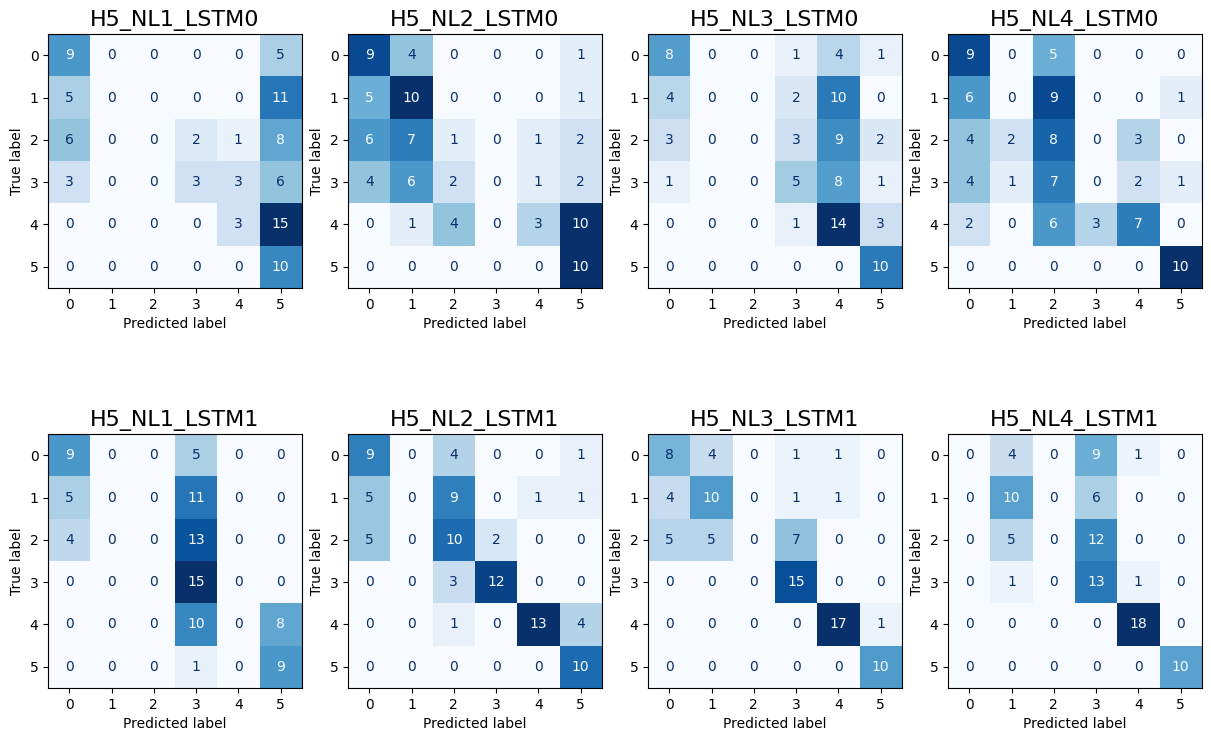


------------ LOSSES ------------



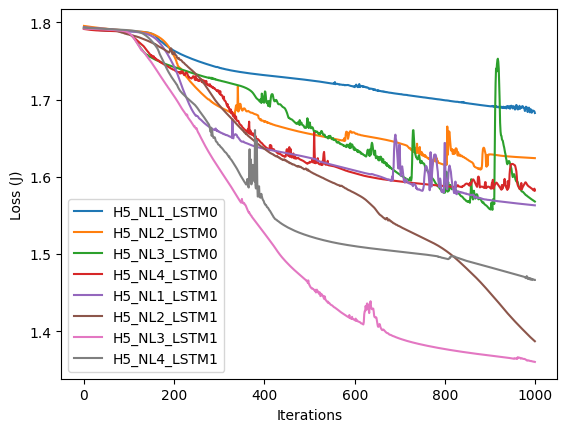


------------ ACCURACIES ------------

            H5_NL1_LSTM0  H5_NL2_LSTM0  H5_NL3_LSTM0  H5_NL4_LSTM0  \
accuracy %     27.777778     36.666667     41.111111     37.777778   

            H5_NL1_LSTM1  H5_NL2_LSTM1  H5_NL3_LSTM1  H5_NL4_LSTM1  
accuracy %     36.666667          60.0     66.666667     56.666667  


In [12]:
# Testing different values for exp_num_layers

exp_hidden_size = [5]*8
exp_num_layers = [1,2,3,4]*2
exp_use_lstm = [False]*4 + [True]*4

acc, hd_sz, num_lay, use_lstm = evaluateModels(exp_hidden_size=exp_hidden_size, exp_num_layers=exp_num_layers, exp_use_lstm=exp_use_lstm)

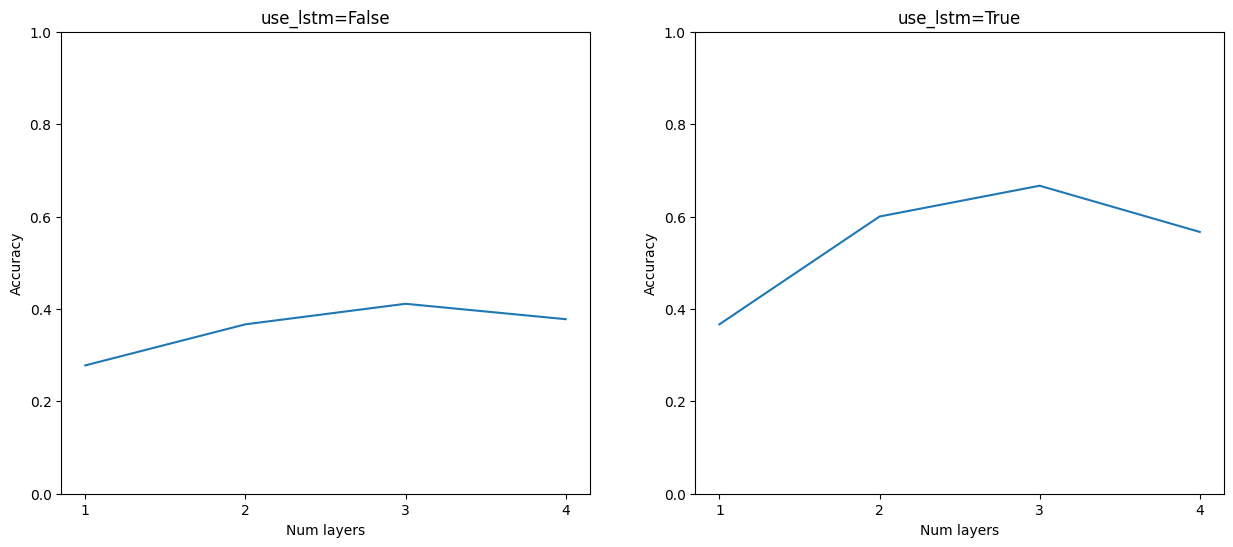

In [13]:
# Plot the evolution of accuracy with respect to num_layers, for both lstm False and True.
f, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(num_lay[:4], acc[:4])
axes[0].set_xlabel("Num layers")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_title("use_lstm=False")
axes[0].set_xticks(num_lay[:4])

axes[1].plot(num_lay[-4:], acc[-4:])
axes[1].set_xlabel("Num layers")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim([0, 1])
axes[1].set_title("use_lstm=True")
axes[1].set_xticks(num_lay[-4:])

plt.show()

[<class 'torch.optim.adam.Adam'>, <class 'torch.optim.sgd.SGD'>, <class 'torch.optim.rmsprop.RMSprop'>, <class 'torch.optim.adagrad.Adagrad'>, <class 'torch.optim.adam.Adam'>, <class 'torch.optim.sgd.SGD'>, <class 'torch.optim.rmsprop.RMSprop'>, <class 'torch.optim.adagrad.Adagrad'>]
------------ TRAINING ------------

Training: H5_NL2_LSTM0
Final loss: 1.7893260717391968
Test Accuracy: 0.1111
Training: H5_NL2_LSTM0
Final loss: 1.7915855646133423
Test Accuracy: 0.1667
Training: H5_NL2_LSTM0
Final loss: 1.7900065183639526
Test Accuracy: 0.1556
Training: H5_NL2_LSTM0
Final loss: 1.7865852117538452
Test Accuracy: 0.1111
Training: H5_NL2_LSTM1
Final loss: 1.7903270721435547
Test Accuracy: 0.1556
Training: H5_NL2_LSTM1
Final loss: 1.7894207239151
Test Accuracy: 0.1111
Training: H5_NL2_LSTM1
Final loss: 1.790942907333374
Test Accuracy: 0.1111
Training: H5_NL2_LSTM1
Final loss: 1.7899194955825806
Test Accuracy: 0.1111

------------ CONFUSION MATRICES ------------



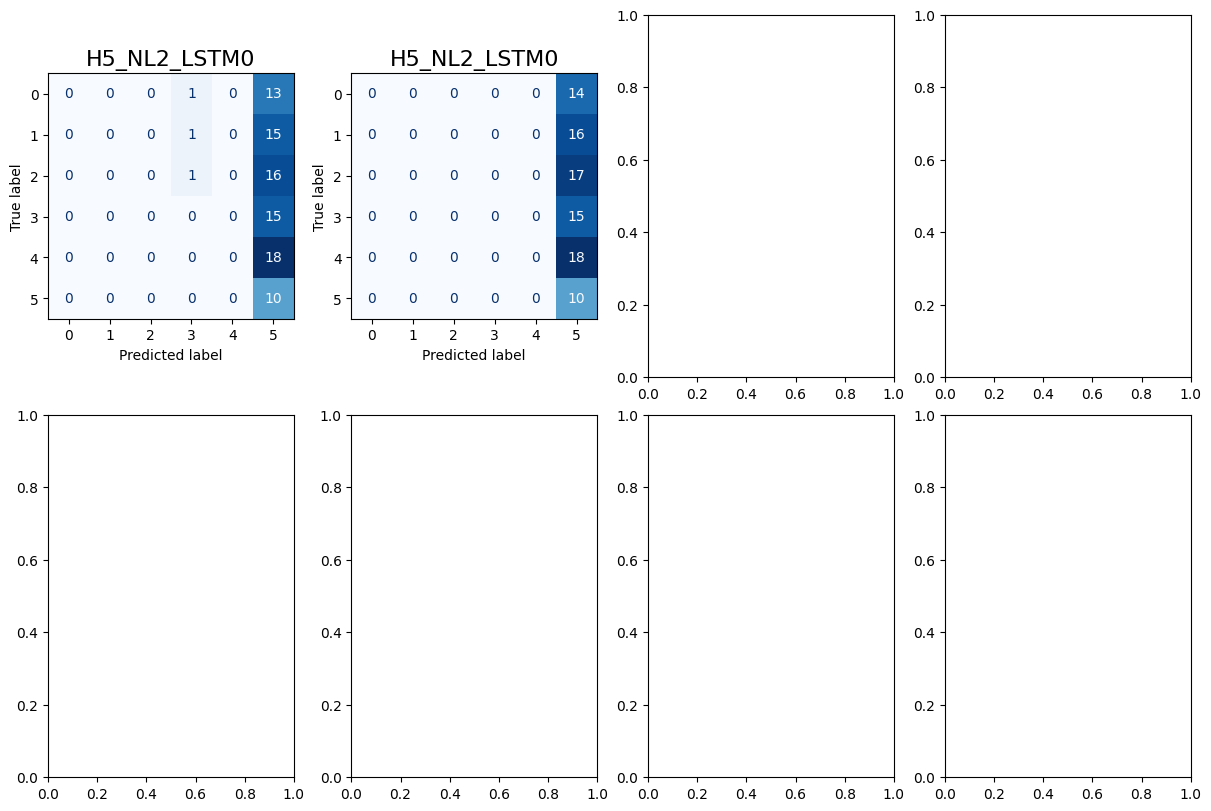


------------ LOSSES ------------



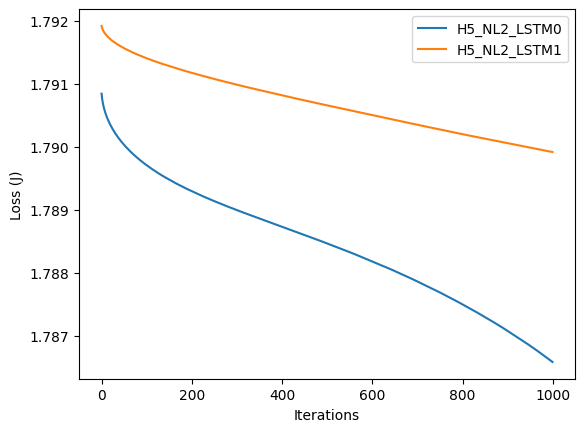


------------ ACCURACIES ------------

            H5_NL2_LSTM0  H5_NL2_LSTM1
accuracy %     11.111111     11.111111


In [22]:
# Testing different optimizers

exp_hidden_size = [5]*8
exp_num_layers = [2]*8
exp_use_lstm = [False]*4 + [True]*4
optimizers = ["default", "SGD", "RMSprop", "Adagrad"]*2

acc, hd_sz, num_lay, use_lstm = evaluateModels(exp_hidden_size=exp_hidden_size, exp_num_layers=exp_num_layers, exp_use_lstm=exp_use_lstm, optimizers=optimizers)

2


ValueError: x and y must be the same size

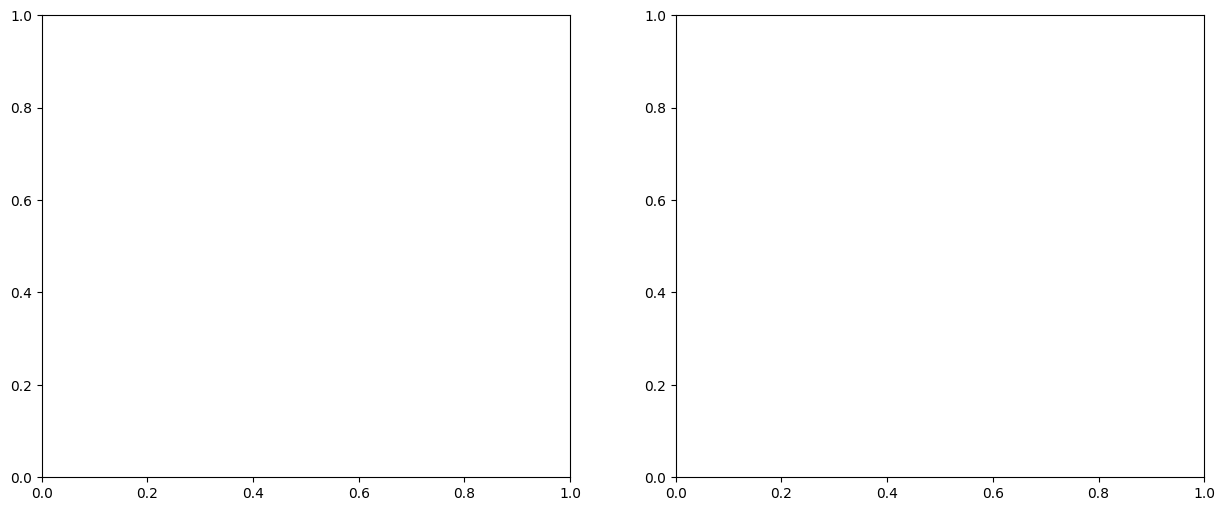

In [17]:
# Plot the evolution of accuracy with respect to the optimizer used, for both lstm False and True.
f, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter([1, 2, 3, 4], acc[:4])
axes[0].set_xlabel("Optimizer used")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])
axes[0].set_title("use_lstm=False")
axes[0].set_xticks(optimizers[:4])

axes[1].scatter([1, 2, 3, 4], acc[-4:])
axes[1].set_xlabel("Num layers")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim([0, 1])
axes[1].set_title("use_lstm=True")
axes[1].set_xticks(optimizers[-4:])

plt.show()

<font size='+3'>TODO: Change ACTIVATION FUNCTIONS</font>

Notes:
- Considerar usar un random_seed para quedarnos solo con los mejores resultados
- En este nos interesa guardar solo el ultimo estado ya que ese estado contiene a su vez los otros anteriores.

# Ex 2. Cryptoanalysis with corrupted messages using RNNs/LSTMs

In [14]:
'''
Similar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis.

For this exercise, you have training.pkl and testing_corrupted.pkl files.
These files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test.
Similar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with
7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted
with a new char ("-"), while the training set has been transmitted correctly.

Each 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.

Example:

Received Ciphertext:   'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH'
Correct Ciphertext (Not provided):   'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH'
Ground truth:   'HEWENTALLOUTANDGAVEITHISBESTSHOT'

Steps :
1. Discover the keyword used to encrypt the plaintext data. (hint: use Vigenère table and some samples)
2. Design/Implement an strategy to train the model so that it can be robust to missing characters in the testing samples ( to be discussed in class )
3. Train a sequential model to decode the corrupted test data.
4. Evaluate the decoding accuracy for the test set in terms of characters that were not corrupted or corrupted independently.
5. Try to improve the performance by applying some improvements over the model: stacked LSTMs,
hidden_sizes, embedding_size, optimizer, data augmentation during training, etc...
6. Visualize and discuss on the final results.
'''

'\nSimilar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis.\n\nFor this exercise, you have training.pkl and testing_corrupted.pkl files.\nThese files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test.\nSimilar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with\n7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted\nwith a new char ("-"), while the training set has been transmitted correctly.\n\nEach 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.\n\nExample:\n\nReceived Ciphertext:   \'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH\'\nCorrect Ciphertext (Not provided):   \'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH\'\nGround truth:   \'HEWENTALLOUTANDGAVEITHISBESTSHOT\'\n\nSteps :\n1. Discover the keyword used to encrypt the plaintext data. (hint: use 

In 2. being robust means getting at least 87.5% accuracy (all non corrupt chars).

For 3. we should have 2 losses, and 2 accuracies, 1 for normal chars, and 1 for corrupted chars. We should try to get 95% accuracy, 100% of the 87,5% correct chars and more or less 50% of corrupted chars are solved correctly.

Advice: do data augmentation/transformation to try to make the training data look more like the testing data.

# Sol 2.

## 1. Discover the keyword used to encrypt the plaintext data

In [15]:
# Load train and test files into memory
pkl_file = open(datadir+'training.pkl', 'rb')
train = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(datadir+'testing_corrupted.pkl', 'rb')
test = pickle.load(pkl_file)
pkl_file.close()

vocabulary = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'] # Predefined vocabulary

In [16]:
def int_to_vocabulary(message, vocabulary):
    decoded = ''
    for letter_code in message:
        decoded += vocabulary[letter_code]
    return decoded

In [17]:
keyword = (train[0][0]-train[0][1]) % len(vocabulary)
print(f'Train Message encrypted:       {int_to_vocabulary(train[0][0],vocabulary)}')
print( 'The keyword for en/decryption: {kw}'.format(kw=int_to_vocabulary(keyword, vocabulary)))
print(f'Train Message decrypted:       {int_to_vocabulary(train[0][1],vocabulary)}')
print('\nThe keyword (length {l}) is: {kw}'.format(l=7, kw=int_to_vocabulary(keyword, vocabulary)[:7]))

Train Message encrypted:       XJEQRNSIFXAKQTDPKCNYOTLBQFOLQYVY
The keyword for en/decryption: PYTORCHPYTORCHPYTORCHPYTORCHPYTO
Train Message decrypted:       ILLCALLTHEMTOMORROWWHENICOMEBACK

The keyword (length 7) is: PYTORCH


## 2.Design/Implement an strategy to train the model

Proposed strategy: train as if there was another character in the vocabulary

Problems of this strategy: this character won't be trained properly

Solution to this problem: we could intentionally corrupt training data so the model learns how to interpret those appropiately

In [18]:
corr_vocab = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ-'] # Corrupted vocabulary

In [19]:
class CorruptedDataset(Dataset):
    # the data is in the form [img_name, boundaries]
    def __init__(self, data, p=0.125, corruption = True, corrupted_char=26):
        self.data = data.to(device)
        self.corr_prob = p
        self.corr_char = corrupted_char
        self.shape = data.shape
        self.batch_size = None
        self.corruption = corruption

        def corrupt_tensor(tensor):
            corrupted_idx = np.random.uniform(size=tensor.shape[0]) < self.corr_prob
            corr_item = tensor.clone()
            corr_item[corrupted_idx==True] = self.corr_char
            return corr_item
        self.transform = corrupt_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (self.corruption):
            return self.transform(self.data[idx])
        return self.data[idx]

In [20]:
class DecrypterNetwork(nn.Module):
    def __init__(self,
                 hidden_size : int = 8,
                 num_layers = 1,
                 num_letters = 26,
                 letters_embedding_size : int = 8,
                 use_lstm : bool = False):
        # Define RNN or LSTM architecture
        super().__init__()
        self.hidden_size = hidden_size
        self.num_letters = num_letters
        self.letters_embedder = torch.nn.Embedding(num_letters, letters_embedding_size)
        self.use_lstm = use_lstm
        self.softmax = nn.Softmax(dim=1)
        if(use_lstm):
            self.rnn = nn.LSTM(input_size = letters_embedding_size, hidden_size = hidden_size,
                               num_layers=num_layers, batch_first = True)
        else:
            self.rnn = nn.RNN(input_size = letters_embedding_size, hidden_size = hidden_size,
                              num_layers=num_layers, batch_first = True)
        self.last_linear = nn.Linear(hidden_size,num_letters)

    def forward(self, X):
        N = X.shape[0]
        L = X.shape[1]
        embedded_letters = self.letters_embedder(X)
        # Get hidden states for all letters in the sequence
        hidden_states,_ = self.rnn(embedded_letters)
        # In case of multiple input sequneces flat (N,L,hidden_size) to (N*L,hidden_size) for linear layer
        hidden_states_concat = hidden_states.reshape(-1,self.hidden_size)
        # Get letters probability using the hidden states for each position in the sequence
        letters_loggits = self.last_linear(hidden_states_concat)
        # Use soft-max over logits and reshape to format (N,L,num_letteres)
        letters_probs = self.softmax(letters_loggits).reshape(N, L, self.num_letters)
        return letters_probs

In [21]:
def train_test(model, num_epochs, loss_fn, optimizer,
            train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted):

    model = model.to(device)
    # train_encrypted_loader = train_encrypted_loader.data.to(device)
    train_decrypted = train_decrypted.to(device)
    test_encrypted = test_encrypted.to(device)
    test_decrypted = test_decrypted.to(device)

    train_loss_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }
    test_loss_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }
    train_acc_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }
    test_acc_hist = { "overall" : [], "corrupted" : [], "non-corrupted" : [] }

    for epoch in range(num_epochs):
        # TRAINING AND BACK-PROPAGATION
        model.train()
        optimizer.zero_grad()
        batch = next(iter(train_encrypted_loader))
        letters_probs = model(batch)
        train_loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                                        train_decrypted)
        train_loss.backward() # Backpropagate
        optimizer.step() # Update weights
        
        _, maxprob_letters_idx = letters_probs.max(dim=2) # get letter with maximum prob
        train_accuracy = ((maxprob_letters_idx==train_decrypted)*1.0).mean() # compute accuracy
        train_loss_hist["overall"].append(train_loss.item())
        # train_loss_hist["corrupted"] = torch.sum(train_loss[batch == 26])
        train_acc_hist["overall"].append(train_accuracy.item())

        # EVALUATION
        model.eval()
        letters_probs = model(test_encrypted)
        test_loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                                                test_decrypted)
        
        _, maxprob_letters_idx = letters_probs.max(dim=2) # get letter with maximum prob
        test_accuracy = ((maxprob_letters_idx==test_decrypted)*1.0).mean() # compute accuracy
        test_loss_hist["overall"].append(test_loss.item())
        test_acc_hist["overall"].append(test_accuracy.item())

        if(epoch%50==0):
            print(f'Epoch {epoch} \t Train Loss {round(train_loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(test_accuracy.item()*100,1)}')
    print(f'Final Epoch \t Train Loss {round(train_loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(test_accuracy.item()*100,1)}')
    return model, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [22]:
train_encrypted = torch.concat([train_sample[0].unsqueeze(0) for train_sample in train],dim=0)
train_decrypted = torch.concat([train_sample[1].unsqueeze(0) for train_sample in train],dim=0)
test_encrypted = torch.concat([test_sample[0].unsqueeze(0) for test_sample in test],dim=0)
test_decrypted = torch.concat([test_sample[1].unsqueeze(0) for test_sample in test],dim=0)

train_encrypted_dataset = CorruptedDataset(train_encrypted)
train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

decrypter_network = DecrypterNetwork(num_layers=1,
                                     num_letters=len(corr_vocab),
                                     hidden_size=16,
                                     use_lstm=True)

num_epochs=600
CE_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-3)

In [23]:
decrypter_network, loss_hist, test_loss_hist, acc_hist = train_test(decrypter_network,
                                                            num_epochs,
                                                            CE_loss,
                                                            optimizer,
                                                            train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

Epoch 0 	 Train Loss 3.301 	 Test Loss 3.297 	 Test Acc. (%)  8.3
Epoch 50 	 Train Loss 3.107 	 Test Loss 3.105 	 Test Acc. (%)  12.3
Epoch 100 	 Train Loss 2.916 	 Test Loss 2.925 	 Test Acc. (%)  13.5


KeyboardInterrupt: 

In [ ]:
plt.plot(loss_hist, '-.r', linewidth=1.0, label='train_loss')
plt.plot(test_loss_hist,'-b', linewidth=1.0, label='test_loss')
plt.xlabel('train step', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend()
plt.show()

plt.plot(acc_hist, linewidth=3.0, label='test_acc')
plt.xlabel('train step', fontsize=14)
plt.ylabel('accuracy(%)', fontsize=14)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend()
plt.show()

decrypter_network = decrypter_network.to(device)
for idx_sample in range(0,10):
    # Inference over single training sequence
    letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0).to(device))
    # get index of letter with max probability
    _,maxprob_letters_idx = letters_probs.max(dim=2)
    print('--------------------------------------')
    print(f'Original Message encrypted: {int_to_vocabulary(test[idx_sample][0],corr_vocab)}')
    print(f'Message decrypted: {int_to_vocabulary(test[idx_sample][1],vocabulary)}')
    print(f'Prediction Message decrypted: {int_to_vocabulary(maxprob_letters_idx[0],corr_vocab)}')
    acc = (1.0*(maxprob_letters_idx[0]==test[idx_sample][1].to(device))).mean().item()
    print(f'Prediction Message Accuracy : {round(acc,2)}')